# 1D heat conduction example
Jean C. Ragusa

Texas A&M University

jean.ragusa@tamu.edu

# General problem definition
Consider a 1D **nonlinear** heat conduction problem
$$ \rho C_p\frac{\partial T}{\partial t} -\frac{\partial x}{\partial x} k(x,t,T)\frac{\partial T}{\partial x} = q(x,t)
$$
where the conductivity is a function of temperature. 

As an example, we can use
$$k(x,t,T)=k^0(x,t) + k^1(x,t)T$$
Hence, we are solving:
$$ \rho C_p\frac{\partial T}{\partial t} -\frac{\partial x}{\partial x}(k^0(x,t) + k^1(x,t) T) \frac{\partial T}{\partial x} = q(x,t)
$$
**Boundary conditions**:
- reflective at $x=0$: $\quad \left.\tfrac{dT}{dx}\right|_0 = 0$
- imposed temperature (Dirichlet bc) at $x=L$: $\quad T(L,t)=T_{bc}(t)$

More generally, on the boundary, one may have :
* a natural boundary condition $$ a(t) T + k\partial_n T = c(t)$$
* or a fixed, imposed value $$ T(t) = \text{given}(t)$$

For example, the convective heat transfer boundary value can be written as:

$$
-k\partial_n T  = h(t)(T - T^{\infty}(t))
$$

So $a(t)=h(t)$, the convective heat exchange coefficient, and $c(t)=h(t) T^\infty(t)$, with $T^\infty(t)$ the far-field cooling temperature.

**Linear version** of the problem: set $k^1(x,t) = 0$

### load python modules

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import sparse
from scipy.sparse import linalg
import time

# 1-D slab mesh and material properties
We give material properties "per zone" and then replicate them as many times as needed to assign them to a mesh cell (mesh resolution is a refinement of the material zone layout).

In [2]:
def create_slab_mesh(n_ref,zone_widths):
    # input: 
    #    n_ref: integer (how many times each zone is to be refined)
    #    zone_widths: array of zone widths
    # output:
    #    x: array of cell interface positions
    #    dx: array of cell widths
    #    cell2mat: given a cell index, this returns the material ID in that cell
    
    if len(zone_widths) != len(n_ref):
        raise ValueError("dx and nref should have same length")
    
    # compute cell widths
    dx = np.repeat(zone_widths/n_ref, n_ref)
    
    # cell interfaces
    x = np.zeros(len(dx)+1)
    for i in range(len(dx)):
        x[i+1] = x[i] + dx[i]
        
    # create cell2mat array
    cell2mat = np.repeat( np.arange(len(zone_widths)), n_ref)
    
    # middle point
    xm = 0.5 * (x[1:]+x[:-1])
    
    return x, xm, dx, cell2mat

### small demo: 2-zones, of width 0.4 and 0.1, and a refinement factor of 10 in zone-1 and 4 in zone-2

In [3]:
x, xm, dx, cell2mat = create_slab_mesh(n_ref=np.array([10,4],dtype=int),dx_=np.array([0.4,0.1]))

print('cell interfaces=',x)
print('\ncell middles   =',xm)
print('\ncell widths    =',dx)
# plot
plt.figure()
ax = plt.gca()
ax.axes.yaxis.set_ticklabels([])
ax.yaxis.set_ticks_position('none') 
plt.scatter(x, np.zeros(len(x)))
plt.scatter(xm, np.zeros(len(xm)),marker='s')
plt.title('location of cell interfaces (circles) and middle (squares)')
plt.grid()
plt.show()

TypeError: create_slab_mesh() got an unexpected keyword argument 'dx_'

# Linear version of the problem: system matrix

One way the discrete expression can be obtained is by integrating the governing equation for $x \in [x_{i-1/2},x_{i+1/2}]$:

$$
\int_{x_{i-1/2}}^{x_{i+1/2}}dx\, \left(\rho C_p(x,t) \frac{\partial  T}{\partial  t} -\frac{\partial }{\partial x} k^0(x,t)\frac{\partial T}{\partial x} = q(x,t) \right)
$$

Thus, we obtain a **vertex-centered** simple finite difference:

$$
\left(\frac{\rho C_p(t)_{i+1/2}\Delta x_{i+1/2}}{2} + \frac{\rho C_p(t)_{i-1/2}\Delta x_{i-1/2}}{2}\right) \frac{d T_i}{dt}
-k^0_{i+1/2}\frac{T_{i+1}-T_i}{\Delta x_{i+1/2}}
+
k^0_{i-1/2}\frac{T_i-T_{i-1}}{\Delta x_{i-1/2}}
=
\frac{q_{i+1/2}\Delta x_{i+1/2}}{2} + \frac{q_{i-1/2}\Delta x_{i-1/2}}{2}
$$

where the full integer indices denote nodal (vertex) values and the half-integer indices denote cell values. $\Delta x_{i+1/2}=x_{i+1}-x_i$.

If we used backward Euler in time 
$$
\frac{d T_i}{dt} \approx \frac{T_i-T_i^n}{\Delta t}
$$
where temperature without any superscript are evaluated at time $n+1$.


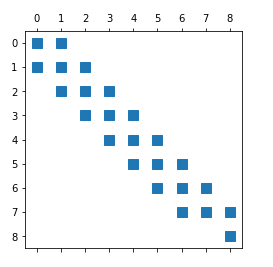

Resulting linear system:
$$ A T = b$$
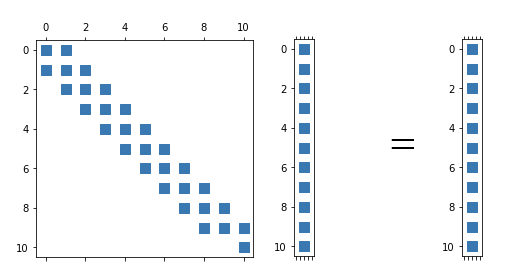

# build linear system matrix

In [5]:
def build_matrix_at_once(rhocp_arr, cond_arr, bc, xm, dx, mat2cell, t, dt):
    # input: 
    #    cond_arr: conductivity array (length = number of material zones)
    #    xm   : array of cell middle points (length = number of cells)
    #    dx   : array of cell widths (length = number of cells)
    #    cell2mat: given a cell index, this returns the material ID in that cell
    # output:
    #    K: matrix

    # number of cells, points
    n_cells = len(dx)
    n_pts   = n_cells + 1
    
    # evaluate mat property per cell
    cond_ = cond_arr[mat2cell]
    rhocp_ = rhocp_arr[mat2cell]
    cond = np.zeros(n_cells)
    rhocp = np.zeros(n_cells)
    for i,(kfunc,rhocpfunct,xmiddle) in enumerate(zip(cond_,rhocp_,xm)):
        cond[i] = kfunc(xmiddle,t)
        rhocp[i] = rhocpfunct(xmiddle,t)
    
    # matrix
    K = sparse.lil_matrix((n_pts,n_pts))
    for i in range(0,n_pts):
        if i>0:
            K[i,i-1] = -cond[i-1]/dx[i-1]
            K[i,i  ] = cond[i-1]/dx[i-1] + rhocp[i-1]*dx[i-1]/2/dt
        if i<n_pts-1:
            K[i,i+1] = -cond[i  ]/dx[i  ]
            K[i,i  ]+= cond[i]/dx[i] + rhocp[i]*dx[i]/2/dt

    # apply left bc
    if bc["left"]["type"] == "natural":
        K[0,0] += bc["left"]["value_a"]
    elif bc["left"]["type"] == "dirichlet":
        K[0,:2] = 0.
        K[0,0]  = 1.
    else:
        raise ValueError("unknown bc type on left")
        
    # apply right bc
    if bc["right"]["type"] == "natural":
        K[-1,-1] += bc["right"]["value_a"]
    elif bc["right"]["type"] == "dirichlet":
        K[-1,-2:] = 0.
        K[-1,-1]  = 1.
    else:
        raise ValueError("unknown bc type on right")

    return K

# build linear system rhs

In [6]:
def build_rhs_at_once(rhocp_arr, qext_arr, bc, xm, dx, mat2cell, t, dt, T_prev):
    # number of cells, points
    n_cells = len(dx)
    n_pts   = n_cells + 1

    # evaluate src property per cell
    qext_  = qext_arr[mat2cell]
    rhocp_ = rhocp_arr[mat2cell]
    qext  = np.zeros(n_cells)
    rhocp = np.zeros(n_cells)
    for i,(qfunc,rhocpfunct,xmiddle) in enumerate(zip(qext_,rhocp_,xm)):
        qext[i]  = qfunc(xmiddle,t)
        rhocp[i] = rhocpfunct(xmiddle,t)
    
    #  rhs
    rhs = np.zeros(n_pts)
    rhs[:-1] += qext*dx/2 + rhocp*dx/2/dt*T_prev[:-1]
    rhs[1:]  += qext*dx/2 + rhocp*dx/2/dt*T_prev[1:]
    
    # apply left bc
    if bc["left"]["type"] == "natural":
        rhs[0] += bc["left"]["value_c"]
    elif bc["left"]["type"] == "dirichlet":
        rhs[0] = bc["left"]["value"]
    else:
        raise ValueError("unknown bc type on left")
        
    # apply right bc
    if bc["right"]["type"] == "natural":
        rhs[-1] += bc["right"]["value_c"]
    elif bc["right"]["type"] == "dirichlet":
        rhs[-1] = bc["right"]["value"]
    else:
        raise ValueError("unknown bc type on right")

    return rhs

# routine that builds the whole linear system and solves for $T$

In [7]:
def solve_linear_td(rhocp_arr, cond_arr, qext_arr, bc, xm, dx, matcell, times, T_init):
    ntimes = len(times)
    npts = len(x)
    T = np.zeros((npts, ntimes))
                 
    # make sure the initial guess satisfies the Dirichlet BC
    if bc["left"]["type"] == "dirichlet":
        T_init[0] = bc["left"]["value"]
    if bc["right"]["type"] == "dirichlet":
        T_init[-1] = bc["right"]["value"]
        
    T[:,0] = T_init[:]
                 
    for it in range(1,ntimes):
        t = times[it]
        dt = t - times[it-1]
        
        # build linear system
        A = build_matrix_at_once(rhocp_arr, cond_arr, bc, xm, dx, mat2cell, t, dt)
        rhs = build_rhs_at_once(rhocp_arr, qext_arr, bc, xm, dx, mat2cell, t, dt, T[:,it-1])

        # solve linear system
        T[:,it] = linalg.spsolve(A.tocsc(), rhs)
    
    return T

# problem definition and linear solve
## 1 material, mat prop are piece-wise constant

Max T value =  1359.7789173855672
Min T value =  299.9999999999361


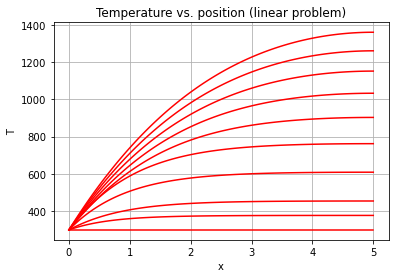

In [8]:
# rho-cp functions per zone
rhocp_arr = []
rhocp_arr.append( lambda x,t: 2.0 + 0.*x + 0.*t )
rhocp_arr = np.asarray(rhocp_arr)

# conductivity functions per zone
cond_arr = []
cond_arr.append( lambda x,t: (2.0 + 0.*x)*(t<2) + (4.0 + 0.*x)*(t>=2) )
cond_arr = np.asarray(cond_arr)

# external volumetric heat source functions per zone
qext_arr = []
qext_arr.append( lambda x,t: (350.0 + 0.*x)*(t<1) + (700.0 + 0.*x)*(t>=1) )
qext_arr = np.asarray(qext_arr)

# geometry
width   = np.array([ 5.])
n_ref = np.array([100], dtype=int)

x, xm, dx, mat2cell = create_slab_mesh(n_ref, width)

# time
Tend=4
ntimes=10
times = np.linspace(0,Tend,ntimes)

# boundary conditions
bc = {}
T_dir = 300.
bc_dir = {"type": "dirichlet", "value": T_dir}
bc_sym = {"type": "natural"  , "value_a": 0., "value_c": 0.}

bc["left"]  = bc_dir
bc["right"] = bc_sym

# solve
# T_init = np.zeros(len(x))
T_init = np.ones(len(x)) * T_dir
T_lin = solve_linear_td(rhocp_arr, cond_arr, qext_arr, bc, xm, dx, mat2cell, times, T_init)
print('Max T value = ',np.max(T_lin))
print('Min T value = ',np.min(T_lin))

plt.figure()
for it in range(ntimes):
    plt.plot(x,T_lin[:,it],'r', label='num')
plt.xlabel('x')
plt.ylabel('T')
plt.title('Temperature vs. position (linear problem)')
plt.grid(True)

## 2 materials, mat prop are piece-wise constant
Linear heat conduction
$$ -\frac{d}{dx} k^0(x)\frac{dT}{dx} = q(x) $$


| Zone ID | $x$   | $k^0$ | $q$ |
| :---    | :---: | ---   | --- |
| I  | \begin{equation}x \in [0.0, 5.0]\end{equation} | 2.0  |  350. |  
| II | \begin{equation}x \in [5.0, 8.0]\end{equation} | 5.0  |   50. | 

Max T value =  1038.9948499479085
Min T value =  299.9999999999505


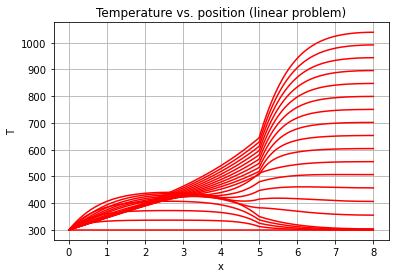

In [9]:
# rho-cp functions per zone
rhocp_arr = []
rhocp_arr.append( lambda x,t: 2.0 + 0.*x + 0.*t )
rhocp_arr.append( lambda x,t: 3.0 + 0.*x + 0.*t )
rhocp_arr = np.asarray(rhocp_arr)

# conductivity functions per zone
cond_arr = []
cond_arr.append( lambda x,t: (2.0 + 0.*x)*(t<2) + (4.0 + 0.*x)*(t>=2) )
cond_arr.append( lambda x,t: (5.0 + 0.*x)*(t<2) + (1.0 + 0.*x)*(t>=2) )
cond_arr = np.asarray(cond_arr)

# external volumetric heat source functions per zone
qext_arr = []
qext_arr.append( lambda x,t: (350.0 + 0.*x)*(t<1) + (0.0 + 0.*x)*(t>=1) )
qext_arr.append( lambda x,t: (0.0 + 0.*x)*(t<1) + (700.0 + 0.*x)*(t>=1) )
qext_arr = np.asarray(qext_arr)

# geometry
width   = np.array([ 5., 3.])
n_ref = np.array([100, 50], dtype=int)

x, xm, dx, mat2cell = create_slab_mesh(n_ref, width)

# time
Tend=4
ntimes=20
times = np.linspace(0,Tend,ntimes)

# boundary conditions
bc = {}
T_dir = 300.
bc_dir = {"type": "dirichlet", "value": T_dir}
bc_sym = {"type": "natural"  , "value_a": 0., "value_c": 0.}

bc["left"]  = bc_dir
bc["right"] = bc_sym

# solve
T_init = np.ones(len(x)) * T_dir
T_lin = solve_linear_td(rhocp_arr, cond_arr, qext_arr, bc, xm, dx, mat2cell, times, T_init)
print('Max T value = ',np.max(T_lin))
print('Min T value = ',np.min(T_lin))

plt.figure()
for it in range(ntimes):
    plt.plot(x,T_lin[:,it],'r', label='num')
plt.xlabel('x')
plt.ylabel('T')
plt.title('Temperature vs. position (linear problem)')
plt.grid(True)